In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import nltk

from textblob import TextBlob
from langdetect import detect
from nltk.util import ngrams
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentiText

# Import all pickled files and organize it to a usable format

Load game information data

In [2]:
with open('final_game_general_data.pkl','rb') as gamefile:
    game_df = pkl.load(gamefile)

In [3]:
game_df.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player


Load all data related to user comments for games and organize

In [63]:
with open('actual_game_title_3420.pkl','rb') as titlefile:
    game_titles = pkl.load(titlefile)
    
with open('actual_game_platform_3420.pkl','rb') as platformfile:
    game_platforms = pkl.load(platformfile)
    
with open('actual_usernames_3420.pkl','rb') as userfile:
    game_users = pkl.load(userfile)
    
with open('actual_userscores_3420.pkl','rb') as scorefile:
    game_userscores = pkl.load(scorefile)
    
with open('actual_usercomments_3420.pkl','rb') as commentfile:
    game_comments = pkl.load(commentfile)
    
with open('actual_helpfulness_3420.pkl','rb') as helpfulfile:
    game_helpfuls = pkl.load(helpfulfile)


In [64]:
print(f"titles: {len(game_titles)}; platforms: {len(game_platforms)} users: {len(game_users)}; scores: {len(game_userscores)}")
print(f"comments: {len(game_comments)}; helpful rec'd: {len(game_helpfuls)}")

titles: 299879; platforms: 299879 users: 283988; scores: 299879
comments: 299879; helpful rec'd: 283988


### Data Cleaning

In [65]:
filter_comments_df = pd.DataFrame()
filter_comments_df['Title'] = game_titles
filter_comments_df['Platform'] = game_platforms
filter_comments_df['Userscore'] = game_userscores
filter_comments_df['Comment'] = [comment.replace('\n','') for comment in game_comments]

cleaned_comments_df = filter_comments_df[filter_comments_df['Userscore'] < 11]
len(cleaned_comments_df)

283988

In [66]:
cleaned_comments_df['Username'] = [user.replace('\n','').replace(' ','') for user in game_users]
cleaned_comments_df['Helpfulness'] = game_helpfuls

cleaned_comments_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Title,Platform,Userscore,Comment,Username,Helpfulness
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus,24
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin,27
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody,127
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman,22
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA,18


In [67]:
# Get rid of empty comments
cleaned_full_comments_df = cleaned_comments_df[cleaned_comments_df['Comment'] != ' ']


In [68]:
cleaned_full_comments_df.dropna(axis=0, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
cleaned_full_comments_df.reset_index(inplace=True)

In [70]:
cleaned_full_comments_df.drop(columns='index',inplace=True)
cleaned_full_comments_df.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Title,Platform,Userscore,Comment,Username,Helpfulness
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus,24
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin,27
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody,127
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman,22
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA,18


# Text Preprocessing

Get rid of all Non-English reviews/comments

In [71]:
comment_language = []

for i in range(len(cleaned_full_comments_df)):
    try:
        language = detect(cleaned_full_comments_df['Comment'][i])
        comment_language.append(language)
    except:
        language = 'no_lang'
        comment_language.append(language)

In [72]:
len(comment_language), len(cleaned_full_comments_df)

(283983, 283983)

In [74]:
cleaned_full_comments_df['Language'] = comment_language
cleaned_full_comments_df.head(11)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Title,Platform,Userscore,Comment,Username,Helpfulness,Language
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus,24,en
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin,27,en
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody,127,en
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman,22,en
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA,18,en
5,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I think it's funny that you have Zelda haters ...,joei1382,8,en
6,The Legend of Zelda: Ocarina of Time,Nintendo64,9,I played A Link To The Past so many times in m...,Corvix,7,en
7,The Legend of Zelda: Ocarina of Time,Nintendo64,10,The Legend of Zelda: Ocarina of Time is withou...,pittsburghboy91,6,en
8,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"This review contains spoilers, cli...",Nosidda89,6,en
9,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm not kidding when I say that this is the on...,Regeneration13,6,en


In [75]:
english_only_comments_df = cleaned_full_comments_df[cleaned_full_comments_df['Language'] == 'en']
len(english_only_comments_df)

271416

In [76]:
with open('final_3420_english_only_comments_df.pkl', 'wb') as lang_file:
    pkl.dump(english_only_comments_df, lang_file)

## Let's see how well-matched VaderSentiment scores are to actual User scores

**Transform userscores to:**
* 0-4: negative  (-1)
* 5-7: neutral   (0)
* 8-10: positive (1)

In [77]:
sentiment_scores = []

for score in english_only_comments_df['Userscore']:
    if score > 7:
        sentiment_scores.append(1)
    elif 4 < score < 8:
        sentiment_scores.append(0)
    else:
        sentiment_scores.append(-1)
        
english_only_comments_df['sentiment_score'] = sentiment_scores

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [78]:
english_only_comments_df.head(14)

,Title,Platform,Userscore,Comment,Username,Helpfulness,Language,sentiment_score
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus,24,en,1
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin,27,en,1
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody,127,en,1
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman,22,en,1
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA,18,en,1
5,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I think it's funny that you have Zelda haters ...,joei1382,8,en,1
6,The Legend of Zelda: Ocarina of Time,Nintendo64,9,I played A Link To The Past so many times in m...,Corvix,7,en,1
7,The Legend of Zelda: Ocarina of Time,Nintendo64,10,The Legend of Zelda: Ocarina of Time is withou...,pittsburghboy91,6,en,1
8,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"This review contains spoilers, cli...",Nosidda89,6,en,1
9,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm not kidding when I say that this is the on...,Regeneration13,6,en,1


### How well does VaderSentiment capture sentiments of comments?

1. Using VaderSentiment, categorize comments into positive, neutral (aka. mixed feeling), and negative.
2. Using the User Score, categorize the sentiment of each comment (so the column 'sentiment_score' was created).
3. Using the sentiment_score as the actual target value, compare vader's performance to that. 

So:

VaderSentiment score = predicted value
Sentiment score (from User Score) = actual value

In [79]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [80]:
'''
THE PURPOSE:

1. Categorize comments into positive (1), mixed (0), and negative (-1) using vadersentiment
2. Use recall and precision to adjust and determine the score threshold.

We want to do this because we need to distinguish if a user liked/disliked games if finding similar games
to recommend to users. (i.e. we don't want recommend a similar terrible game.)

'''
vader_analyzer = SentimentIntensityAnalyzer()

vadersentiment_scores = []

for review in english_only_comments_df['Comment']:
    compound_score = vader_analyzer.polarity_scores(review)['compound']
    
    if compound_score < -0.1:
        vadersentiment_scores.append(-1)
        
    elif -0.1 <= compound_score <= 0.1:
        vadersentiment_scores.append(0)
        
    else:
        vadersentiment_scores.append(1) 
    

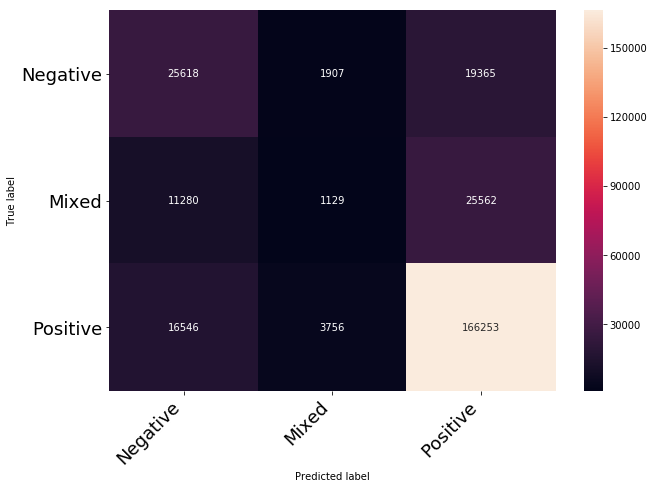

In [81]:
'''
english_only_comments_df['sentiment_score'] --- the actual sentiment scores

vadersentiment_scores --- the predicted sentiment scores
'''

# threshold is below -0.1 for negative and above 0.1 for positive
conf_mat = confusion_matrix(y_true=english_only_comments_df['sentiment_score'], y_pred=vadersentiment_scores)
cm = print_confusion_matrix(conf_mat, class_names=['Negative','Mixed','Positive'])

In [103]:
compare_sent_df = pd.DataFrame(columns=['actual','predicted'])
compare_sent_df['actual'] = english_only_comments_df['sentiment_score']
compare_sent_df['predicted'] = vadersentiment_scores

compare_sent_df[compare_sent_df['actual'] == -1][compare_sent_df['predicted'] == 1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,actual,predicted
357,-1,1
361,-1,1
363,-1,1
366,-1,1
372,-1,1
374,-1,1
376,-1,1
895,-1,1
897,-1,1
901,-1,1


## Before building recommender, need to transform data structure into usable form

In [83]:
'''
Use VaderSentiment to provide sentiment scores to each comment.
'''

actual_sentiment_scores = []

for review in english_only_comments_df['Comment']:
    compound_score = vader_analyzer.polarity_scores(review)['compound']
    actual_sentiment_scores.append(compound_score)
    

In [84]:
english_only_comments_df['vader_score'] = actual_sentiment_scores
english_only_comments_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Title,Platform,Userscore,Comment,Username,Helpfulness,Language,sentiment_score,vader_score
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus,24,en,1,0.3758
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin,27,en,1,0.4157
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody,127,en,1,0.9641
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman,22,en,1,0.9946
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA,18,en,1,0.9622


In [86]:
# Setting up pivot table for actual userscores

df_actual_pivot = pd.pivot_table(english_only_comments_df, values = ['Userscore'],
                                 index = ['Title', 'Platform', 'Username'],
                                 aggfunc = np.mean).unstack()

actual_user_means = df_actual_pivot.mean(axis=0)

df_actual_pivot_demeaned = df_actual_pivot - actual_user_means
df_actual_pivot_demeaned.fillna(0, inplace=True)

# Setting up pivot table for vader rated sentiment scores

df_vader_pivot = pd.pivot_table(english_only_comments_df, values = ['vader_score'],
                                index = ['Title', 'Platform', 'Username'], 
                                aggfunc = np.mean).unstack()

vader_user_means = df_vader_pivot.mean(axis=0)

df_vader_pivot_demeaned = df_vader_pivot - vader_user_means
df_vader_pivot_demeaned.fillna(0, inplace=True)

In [87]:
df_actual_pivot_demeaned.head()

Userscore         \
Username                                      "Harv'sNoBroofMine"Smith $ERIC$   
Title                            Platform                                       
'Splosion Man                    Xbox360                           0.0    0.0   
007: The World is Not Enough     Nintendo64                        0.0    0.0   
2010 FIFA World Cup South Africa PlayStation3                      0.0    0.0   
                                 Xbox360                           0.0    0.0   
3D After Burner II               3DS                               0.0    0.0   

                                                               \
Username                                      $GMoney$GIrdham   
Title                            Platform                       
'Splosion Man                    Xbox360                  0.0   
007: The World is Not Enough     Nintendo64               0.0   
2010 FIFA World Cup South Africa PlayStation3             0.0   
                                 Xbox360                  0.0   
3D After Burner II               3DS                      0.0   

                                                                      \
Username                                      $MOB$-DevilDoggSince96   
Title                            Platform                              
'Splosion Man                    Xbox360                         0.0   
007: The World is Not Enough     Nintendo64                      0.0   
2010 FIFA World Cup South Africa PlayStation3                    0.0   
                                 Xbox360                         0.0   
3D After Burner II               3DS                             0.0   

                                                                      \
Username                                      'Airstrike'I (((evo)))   
Title                            Platform                              
'Splosion Man                    Xbox360               0.0       0.0   
007: The World is Not Enough     Nintendo64            0.0       0.0   
2010 FIFA World Cup South Africa PlayStation3          0.0       0.0   
                                 Xbox360               0.0       0.0   
3D After Burner II               3DS                   0.0       0.0   

                                                          \
Username                                      (Anonymus)   
Title                            Platform                  
'Splosion Man                    Xbox360             0.0   
007: The World is Not Enough     Nintendo64          0.0   
2010 FIFA World Cup South Africa PlayStation3        0.0   
                                 Xbox360             0.0   
3D After Burner II               3DS                 0.0   

                                                                        \
Username                                      (Still)RemainingNameless   
Title                            Platform                                
'Splosion Man                    Xbox360                           0.0   
007: The World is Not Enough     Nintendo64                        0.0   
2010 FIFA World Cup South Africa PlayStation3                      0.0   
                                 Xbox360                           0.0   
3D After Burner II               3DS                               0.0   

                                                                            \
Username                                      *Chris**Faz* *NintendoLover*   
Title                            Platform                                    
'Splosion Man                    Xbox360               0.0             0.0   
007: The World is Not Enough     Nintendo64            0.0             0.0   
2010 FIFA World Cup South Africa PlayStation3          0.0             0.0   
                                 Xbox360               0.0             0.0   
3D After Burner II               3DS                   0.0             0.0   

                                      

In [88]:
df_vader_pivot_demeaned.head()

vader_score         \
Username                                      "Harv'sNoBroofMine"Smith $ERIC$   
Title                            Platform                                       
'Splosion Man                    Xbox360                           0.0    0.0   
007: The World is Not Enough     Nintendo64                        0.0    0.0   
2010 FIFA World Cup South Africa PlayStation3                      0.0    0.0   
                                 Xbox360                           0.0    0.0   
3D After Burner II               3DS                               0.0    0.0   

                                                               \
Username                                      $GMoney$GIrdham   
Title                            Platform                       
'Splosion Man                    Xbox360                  0.0   
007: The World is Not Enough     Nintendo64               0.0   
2010 FIFA World Cup South Africa PlayStation3             0.0   
                                 Xbox360                  0.0   
3D After Burner II               3DS                      0.0   

                                                                      \
Username                                      $MOB$-DevilDoggSince96   
Title                            Platform                              
'Splosion Man                    Xbox360                         0.0   
007: The World is Not Enough     Nintendo64                      0.0   
2010 FIFA World Cup South Africa PlayStation3                    0.0   
                                 Xbox360                         0.0   
3D After Burner II               3DS                             0.0   

                                                                      \
Username                                      'Airstrike'I (((evo)))   
Title                            Platform                              
'Splosion Man                    Xbox360               0.0       0.0   
007: The World is Not Enough     Nintendo64            0.0       0.0   
2010 FIFA World Cup South Africa PlayStation3          0.0       0.0   
                                 Xbox360               0.0       0.0   
3D After Burner II               3DS                   0.0       0.0   

                                                          \
Username                                      (Anonymus)   
Title                            Platform                  
'Splosion Man                    Xbox360             0.0   
007: The World is Not Enough     Nintendo64          0.0   
2010 FIFA World Cup South Africa PlayStation3        0.0   
                                 Xbox360             0.0   
3D After Burner II               3DS                 0.0   

                                                                        \
Username                                      (Still)RemainingNameless   
Title                            Platform                                
'Splosion Man                    Xbox360                           0.0   
007: The World is Not Enough     Nintendo64                        0.0   
2010 FIFA World Cup South Africa PlayStation3                      0.0   
                                 Xbox360                           0.0   
3D After Burner II               3DS                               0.0   

                                                                            \
Username                                      *Chris**Faz* *NintendoLover*   
Title                            Platform                                    
'Splosion Man                    Xbox360               0.0             0.0   
007: The World is Not Enough     Nintendo64            0.0             0.0   
2010 FIFA World Cup South Africa PlayStation3          0.0             0.0   
                                 Xbox360               0.0             0.0   
3D After Burner II               3DS                   0.0             0.0   

                                    

In [89]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

In [90]:
actual_cosine_dists = cosine_similarity(df_actual_pivot_demeaned)

vader_cosine_dists = cosine_similarity(df_vader_pivot_demeaned)

**Setting up recommenders based on actual userscores & vader scores**

In [91]:
actual_cosine_dists

array([[ 1.        , -0.03884555,  0.        , ...,  0.        ,
         0.01033689,  0.00515261],
       [-0.03884555,  1.        ,  0.        , ...,  0.        ,
        -0.0028941 ,  0.        ],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.00359347,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.00234142, -0.00292326],
       [ 0.01033689, -0.0028941 , -0.00359347, ..., -0.00234142,
         1.        ,  0.05796099],
       [ 0.00515261,  0.        ,  0.        , ..., -0.00292326,
         0.05796099,  1.        ]])

In [92]:
actual_cosine_dists = pd.DataFrame(actual_cosine_dists, columns=df_actual_pivot_demeaned.index)
actual_cosine_dists.index = actual_cosine_dists.columns

vader_cosine_dists = pd.DataFrame(vader_cosine_dists, columns=df_vader_pivot_demeaned.index)
vader_cosine_dists.index = vader_cosine_dists.columns
vader_cosine_dists.iloc[0:5,0:5]

Title                                         'Splosion Man  \
Platform                                            Xbox360   
Title                            Platform                     
'Splosion Man                    Xbox360            1.00000   
007: The World is Not Enough     Nintendo64        -0.17924   
2010 FIFA World Cup South Africa PlayStation3       0.00000   
                                 Xbox360            0.00000   
3D After Burner II               3DS                0.00000   

Title                                         007: The World is Not Enough  \
Platform                                                        Nintendo64   
Title                            Platform                                    
'Splosion Man                    Xbox360                          -0.17924   
007: The World is Not Enough     Nintendo64                        1.00000   
2010 FIFA World Cup South Africa PlayStation3                      0.00000   
                                 Xbox360                           0.00000   
3D After Burner II               3DS                               0.00000   

Title                                         2010 FIFA World Cup South Africa  \
Platform                                                          PlayStation3   
Title                            Platform                                        
'Splosion Man                    Xbox360                                   0.0   
007: The World is Not Enough     Nintendo64                                0.0   
2010 FIFA World Cup South Africa PlayStation3                              1.0   
                                 Xbox360                                   0.0   
3D After Burner II               3DS                                       0.0   

Title                                                 3D After Burner II  
Platform                                      Xbox360                3DS  
Title                            Platform                                 
'Splosion Man                    Xbox360          0.0                0.0  
007: The World is Not Enough     Nintendo64       0.0                0.0  
2010 FIFA World Cup South Africa PlayStation3     0.0                0.0  
                                 Xbox360          1.0                0.0  
3D After Burner II               3DS              0.0                1.0

**Setting up recommender based on actual user scores**

In [93]:
def get_similar_games_actual(games_list, n=100):
    
    games = [game for game in games_list if game in actual_cosine_dists.columns]
    games_summed = actual_cosine_dists[games_list].apply(lambda row: np.sum(row), axis=1)
    games_summed = games_summed.sort_values(ascending=False)
    
    ranked_games = games_summed.index[games_summed.isin(games_list)==False]
    ranked_games = ranked_games.tolist()
    
    for g in games_list:
        ranked_games.remove(g)
    
    if n is None:
        return ranked_games
    else:
        return ranked_games[:n]

In [137]:
#games_i_like = [("Baldur's Gate II: Shadows of Amn", 'PC'), ("BioShock",'PlayStation3')]
games_i_like = [("The Legend of Zelda: Breath of the Wild", 'Switch')]

for i, game in enumerate(get_similar_games_actual(games_i_like, 50)):
    print("%d. %s on %s" % (i+1, game[0], game[1]))

1. Dragon Quest Builders on Switch
2. Detention on PlayStation4
3. The Legend of Zelda: Breath of the Wild on WiiU
4. Flinthook on PC
5. Year Walk on WiiU
6. Art Academy: Home Studio on WiiU
7. Starship Defense on DS
8. Bloodborne on PlayStation4
9. Skylanders SuperChargers on WiiU
10. Diddy Kong Racing on Nintendo64
11. The Legend of Zelda: A Link Between Worlds on 3DS
12. Splatoon on WiiU
13. Mega Man 10 on Wii
14. Mario + Rabbids: Kingdom Battle - Donkey Kong Adventure on Switch
15. Baldur's Gate: Dark Alliance on Xbox
16. Mario Kart 8 DLC Pack 2 on WiiU
17. Final Fantasy X-2 on PlayStation2
18. Henry Hatsworth in the Puzzling Adventure on DS
19. Hollow Knight on PC
20. Axiom Verge on WiiU
21. Bangai-O on Dreamcast
22. GoldenEye 007 on Nintendo64
23. Super Mario Odyssey on Switch
24. RIVE: Ultimate Edition on Switch
25. Guacamelee! Super Turbo Championship Edition on WiiU
26. Endless Space 2 on PC
27. SteamWorld Dig 2 on Switch
28. Diablo III: Ultimate Evil Edition on XboxOne
29. Od

**Setting up recommender based on Vadersentiment scores**

In [95]:
def get_similar_games_vader(games_list, n=100):
    
    games = [game for game in games_list if game in vader_cosine_dists.columns]
    games_summed = vader_cosine_dists[games_list].apply(lambda row: np.sum(row), axis=1)
    games_summed = games_summed.sort_values(ascending=False)
    
    ranked_games = games_summed.index[games_summed.isin(games_list)==False]
    ranked_games = ranked_games.tolist()
    
    for g in games_list:
        ranked_games.remove(g)
    
    if n is None:
        return ranked_games
    else:
        return ranked_games[:n]

In [136]:
#games_i_like = [("Baldur's Gate II: Shadows of Amn", 'PC'), ("BioShock",'PlayStation3')]
games_i_like = [("The Legend of Zelda: Breath of the Wild", 'Switch')]

for i, game in enumerate(get_similar_games_vader(games_i_like, 50)):
    print("%d. %s on %s" % (i+1, game[0], game[1]))

1. Star Wars: Episode I Battle for Naboo on Nintendo64
2. Sega Genesis Collection on PlayStation2
3. The Legend of Zelda: Breath of the Wild on WiiU
4. Mario vs. Donkey Kong on GameBoyAdvance
5. Fire Emblem Fates: Special Edition on 3DS
6. Plants vs Zombies: Garden Warfare 2 on XboxOne
7. Star Wars: Rogue Squadron on Nintendo64
8. Sonic Mania on XboxOne
9. Fire Emblem Fates: Birthright on 3DS
10. Shantae: Risky's Revenge on DS
11. ICO on PlayStation2
12. Odin Sphere Leifthrasir on PlayStation4
13. Disney's Toontown Online on PC
14. Gears of War 4 on XboxOne
15. Beyond Good & Evil on PlayStation2
16. Final Fantasy XII: The Zodiac Age on PlayStation4
17. Maximo: Ghosts to Glory on PlayStation2
18. Art Academy: Home Studio on WiiU
19. Code:Realize - Guardian of Rebirth on PlayStationVita
20. Prince of Persia: The Sands of Time on GameCube
21. Child of Light on PlayStation4
22. Shovel Knight: Treasure Trove on Switch
23. Prince of Persia: Warrior Within on PlayStation2
24. WarioWare, Inc.:

# Build the final item-item recommender by finding overlapping game recommendations between Vader and User scores.

In [168]:
games_i_like = [("The Legend of Zelda: Breath of the Wild", 'Switch')]

user_score_recommendations = get_similar_games_actual(games_i_like)
vader_score_recommendations = get_similar_games_vader(games_i_like)

In [155]:
def sentiment_game_recommender(user_list, vader_list, n):
    vader_dict = dict(vader_list)
    final_recommendations = []
    
    for game in user_list: #we want to iterate through the userscore list to preserve actual userscore ranking
        if game[0] in vader_dict:
            if game[1] == vader_dict[game[0]]:
                final_recommendations.append(game)
            else:
                continue
        else:
            continue
            
    return final_recommendations[0:n]
    

In [172]:
for i, game in enumerate(sentiment_game_recommender(user_score_recommendations, vader_score_recommendations, 10)):
    print("%d. %s on %s" % (i+1, game[0], game[1]))

1. The Legend of Zelda: Breath of the Wild on WiiU
2. Art Academy: Home Studio on WiiU
3. Starship Defense on DS
4. Skylanders SuperChargers on WiiU
5. Diddy Kong Racing on Nintendo64
6. Baldur's Gate: Dark Alliance on Xbox
7. SteamWorld Dig 2 on Switch
8. Oddworld: Stranger's Wrath HD on PlayStationVita
9. Bayonetta on Switch
10. Danganronpa: Trigger Happy Havoc on PC
